In [1]:
import numpy as np
import rasterio.plot
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import namedtuple
import numpy as np
from lxml import etree


from burst_translator import BurstMetadata

swath_tif = 'S1A_IW_SLC__1SDV_20200616T022252_20200616T022319_033036_03D3A3_5D11.SAFE/measurement/s1a-iw1-slc-vh-20200616t022253-20200616t022318-033036-03d3a3-001.tiff'
swath_ann = 'S1A_IW_SLC__1SDV_20200616T022252_20200616T022319_033036_03D3A3_5D11.SAFE/annotation/s1a-iw1-slc-vh-20200616t022253-20200616t022318-033036-03d3a3-001.xml'

In [2]:
def jason_get_bounds(index, burst_element):
    # all offsets, even invalid offsets
    offsets_azimuth = offsets(
        np.array([int(val) for val in burst_element.xpath('firstValidSample/text()')[0].split()]),
        np.array([int(val) for val in burst_element.xpath('lastValidSample/text()')[0].split()]),
    )

    # returns the indices of lines containing valid data
    lines_with_valid_data = np.flatnonzero(offsets_azimuth.end - offsets_azimuth.start)

    # get first and last sample with valid data per line
    # x-axis
    valid_offsets_azimuth = offsets(
        np.amin(offsets_azimuth.start[lines_with_valid_data]),
        np.amax(offsets_azimuth.end[lines_with_valid_data]),
    )

    # get the first and last line with valid data
    # y-axis
    valid_offsets_range = offsets(
        np.amin(lines_with_valid_data),
        np.amax(lines_with_valid_data),
    )

    # x-length
    length_azimuth = valid_offsets_azimuth.end - valid_offsets_azimuth.start
    # y-length
    length_range = len(lines_with_valid_data)

    # n-th burst * total lines + first azimuth
    # x-offset
    azimuth_start = index * frame_lines + valid_offsets_azimuth.start

    # [x-offset, y-offset, x-length, y-length]
    range_start = valid_offsets_range.start
    range_end = range_start + length_range
    azimuth_end = azimuth_start + length_azimuth
    return azimuth_start, azimuth_end, range_start, range_end # I think Jason has these backwards

In [3]:
burst = BurstMetadata(swath_tif, swath_ann, 0)

x1, x2, y1, y2 = burst.first_valid_sample, burst.last_valid_sample, burst.first_valid_line, burst.last_valid_line
isce_rectangle = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor='Red')

In [4]:
offsets = namedtuple('offsets', 'start end')

# annotation xml
tree = etree.parse(swath_ann)

# number of lines in burst
frame_lines = int(tree.xpath('./swathTiming/linesPerBurst/text()')[0])

burst_elements = tree.xpath('./swathTiming/burstList/burst')

    
x1, x2, y1, y2= jason_get_bounds(0, burst_elements[0])
jason_rectangle = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor='Yellow')

In [5]:
with rasterio.open(swath_tif) as swath:
    swath_data = swath.read()
magnitude = np.abs(swath_data)

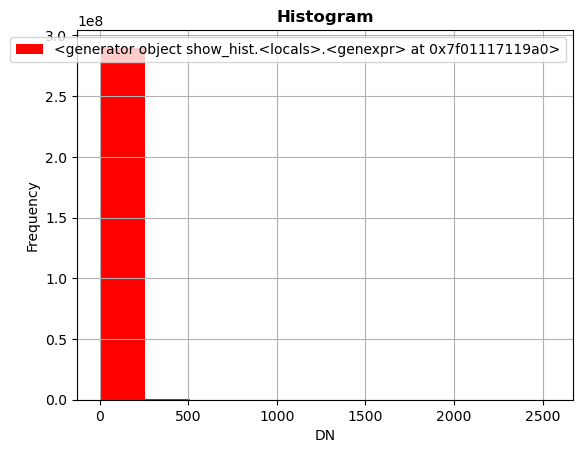

In [1]:
rasterio.plot.show_hist(magnitude, histtype='stepfilled')

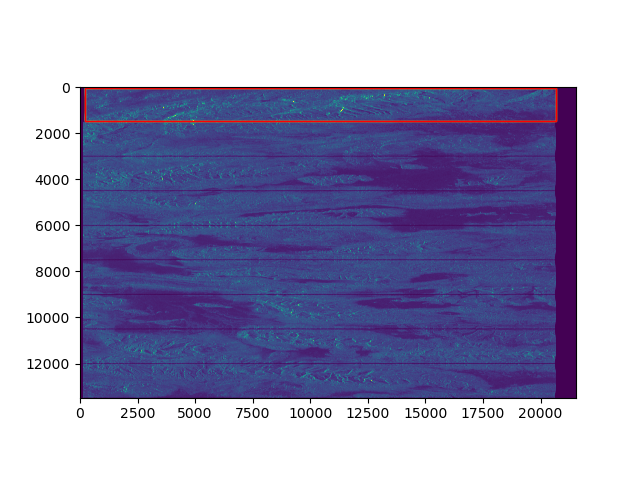

In [6]:
%matplotlib widget
fig, ax = plt.subplots(1, 1)
rasterio.plot.show(magnitude, ax=ax, vmin=0, vmax=250, cmap='viridis')
ax.add_patch(jason_rectangle)
ax.add_patch(isce_rectangle)